 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Séance 1, Notebook 1 : premiers pas</h2>
</div>
    
    

### Objectifs du notebook
    
Ce notebook vise à introduire les grands principes de l'application de l'informatique quantique grâce à la librairie Qiskit. Il vise à **appréhender la manière de coder et simuler des circuits quantiques**. Les bases vues dans ce notebook sont essentielles pour l'application d'algorithmes plus complexes dans la suite du module
    
### Imports
    
Le notebook, comme la plupart des applications qui seront décrites dans ce module, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

import pickle

### 1. Definition d'un circuit

On représente l'algorithme à l'aide d'un circuit. Ceux-ci peuvent être définis et visualisés simplement en qiskit.

Commencons par générer un circuit simple composé d'un seul qubit, sur lequel on applique une porte NOT (X), puis qu'on mesure. 

In [3]:
qc = QuantumCircuit(1)
qc.x(0)
qc.measure_all()

In [4]:
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

### 2. Transpilation du circuit

Le circuit doit être transpilé avant d'être exécuté. L'opération vise à rendre le circuit exécutable sur la machine (il ne doit utiliser que les portes disponibles sur cette machine) et optimisé pour l'exécution (conserver une profondeur minimum, par exemple).
En qiskit, une première passe de transpilation doit être effectuée avant l'envoi du circuit pour exécution, afin d'obtenir un circuit ISA (Instruction Set Architecture). Cette opération se réalise au moyen d'un preset_pass_manager.

In [5]:
#génération d'un pass manager adapté à la machine (ici AerSimulator) et avec un niveau d'optimisation de 1
pass_manager = generate_preset_pass_manager(1, AerSimulator())

In [6]:
#optimisation du circuit au moyen du preset_pass_manager
isa_qc=pass_manager.run(qc)

### 3. Primitives : Sampler et Estimator

Lorsqu'on exécute le circuit sur une machine quantique ou un simulateur, on répète l'exécution du circuit et sa mesure plusieurs fois. 
Cet appel se fait généralement au moyen d'une **primitive** de calcul qui correspond au résultat qu'on cherche à obtenir durant la simulation :
- soit comptabiliser tous les résultats obtenus (e.g: {'0':45 ; '1':55}), au moyen d'un **Sampler**
- soit estimer l'espérance mathématique d'un observable $A$ (soit $⟨\psi|A|\psi⟩$, qui renverra toujours un nombre entier), au moyen d'un **Estimator**

On définit ici le Sampler qui nous servira pour l'expérience, puis on exécute l'expérience

**Note** : les primitives sont pensées pour exécuter plusieurs circuits simultanément. C'est pourquoi on doit spécifier une liste de circuits plutôt qu'un circuit unique.

In [7]:
sampler=Sampler()

job=sampler.run([isa_qc],shots=1024)
result=job.result()

print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=1>)), metadata={'shots': 1024, 'circuit_metadata': {}, 'simulator_metadata': {'omp_enabled': True, 'parallel_experiments': 1, 'max_memory_mb': 15710, 'max_gpu_memory_mb': 0, 'time_taken_execute': 0.0246715, 'time_taken_parameter_binding': 0.0004327}})], metadata={'version': 2})


L'objet renvoyé par le Sampler contient de nombreuses informations sur les paramètres de l'expérience. 

In [8]:
print("Resultat des exécutions : {}".format(result[0].data.meas.array))

print("Decompte des resultats : {}".format(result[0].data.meas.get_counts()))


Resultat des exécutions : [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
Decompte des resultats : {'1': 1024}


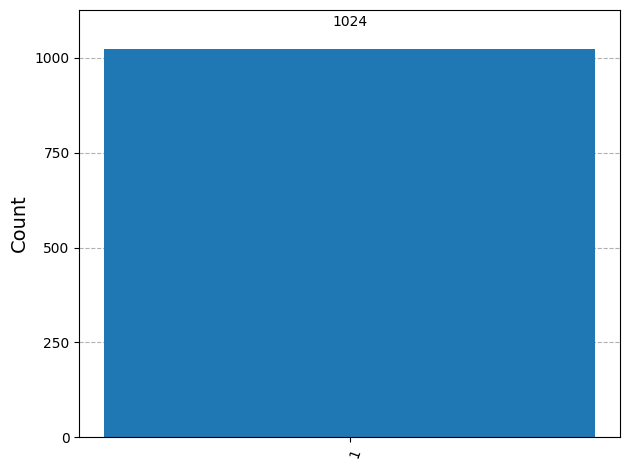

In [9]:
#représentation sous forme d'histogramme
plot_histogram(result[0].data.meas.get_counts())

### 4. Définir un backend pour employer un modèle réaliste

Le Sampler précédent s'appuie sur un simulateur d'ordinateur quantique parfait. Il est possible de modifier ce simulateur pour simuler du bruit.

Au moyen d'un NoiseModel, ajoutons par exemple un **canal de dépolarisation de probabilité p** sur la porte X.

<div class="alert alert-block alert-success">
<b>Rappel :</b> Sur un canal de dépolarisation de probabilité $p$, tous les qubits subissent la transformation suivante indépendemment les uns des autres :
<ul>
    <li>|&psi;⟩ -> |&psi;⟩ avec la probabilité 1-p</li>
    <li>|&psi;⟩ -> X|&psi;⟩ avec la probabilité p/3</li>
    <li>|&psi;⟩ -> Y|&psi;⟩ avec la probabilité p/3</li>
    <li>|&psi;⟩ -> Z|&psi;⟩ avec la probabilité p/3</li>
</ul>
</div>

In [10]:
noise_model = NoiseModel()
prob_depolarisation = 0.05

noise_model.add_all_qubit_quantum_error(
    depolarizing_error(prob_depolarisation, num_qubits=1), ["x"]
)

noisy_sampler = Sampler(options=dict(backend_options=dict(noise_model=noise_model)))

On peut alors réexécuter l'expérience

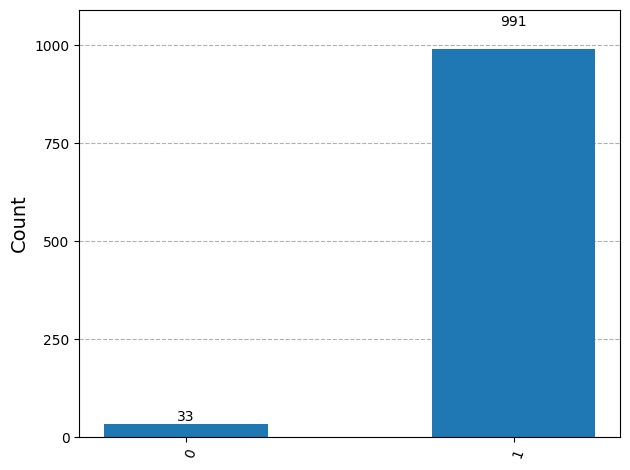

In [11]:
job=noisy_sampler.run([isa_qc],shots=1024)
result=job.result()
#représentation sous forme d'histogramme
plot_histogram(result[0].data.meas.get_counts())

Il est également possible de charger un modèle de bruit correspondant à une machine réelle. Cela se fait via une connexion à la machine, ou via un fichier décrivant ses caractéristiques.

**Note**: la fonctionnalité de chargement depuis un fichier est actuellement dépréciée, sans remplaçant connu.

C:\Users\hugop\AppData\Local\Temp\ipykernel_18276\1189649288.py:4: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


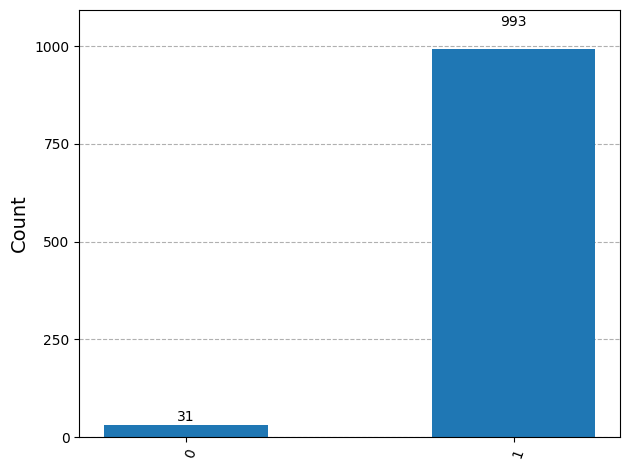

In [12]:
with open('ibm_brisbane_eagle.mdl','rb') as f:
    real_noise_dict = pickle.load(f)

realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


#on execute la même expérience sur ce modele
realistic_sampler = Sampler(options=dict(backend_options=dict(noise_model=realistic_noise_model)))
job=realistic_sampler.run([isa_qc],shots=1024)
result=job.result()
#représentation sous forme d'histogramme
plot_histogram(result[0].data.meas.get_counts())

### 5. Exercices

### 5.1. Transpilation des circuits

<div class="alert alert-block alert-info">
<ul>
    <li>Implémenter et visualiser un circuit à un qubit, appliquant une porte RZ d'angle 10, suivie d'une porte RZ d'angle 5.
    <li>Calculer le circuit ISA équivalent pour le AerSimulator avec un niveau d'optimisation de 1, et le visualiser
    <li>Expliquer la différence de visualisation
</ul>
</div>

<div class="alert alert-block alert-info">
<ul>
    <li>Définir un circuit à 2 qubits permettant d'obtenir puis de mesurer un état de Bell. Vérifier son fonctionnement sur un simulateur idéal.
    <li>Définir un simulateur incluant un canal de polarisation de probabilité 0.02 sur la porte CNOT (CX)
    <li>Réaliser l'expérience sur ce simulateur
</ul>
</div>

In [13]:
qc= QuantumCircuit(1)
qc.rz(10,0)
qc.rz(5,0)
qc.measure_all()
print(qc)

qc_isa=pass_manager.run(qc)
print(qc_isa)

        ┌────────┐┌───────┐ ░ ┌─┐
     q: ┤ Rz(10) ├┤ Rz(5) ├─░─┤M├
        └────────┘└───────┘ ░ └╥┘
meas: 1/═══════════════════════╩═
                               0 
global phase: 5.0664
        ┌────────────┐ ░ ┌─┐
     q: ┤ U1(2.4336) ├─░─┤M├
        └────────────┘ ░ └╥┘
meas: 1/══════════════════╩═
                          0 


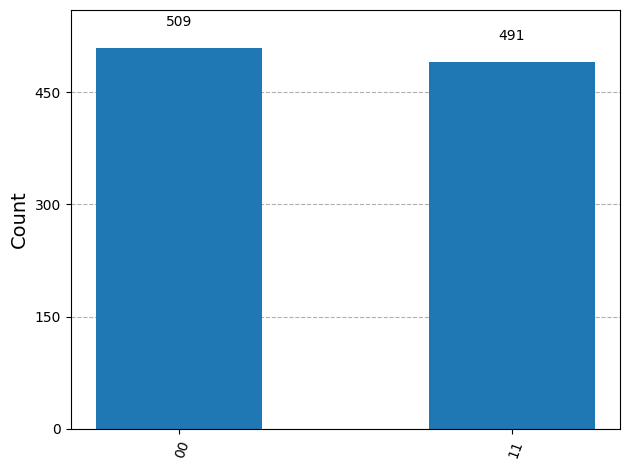

In [14]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

qc.draw()

qc_isa = pass_manager.run(qc)
result= sampler.run([qc_isa], shots=1000).result()
plot_histogram(result[0].data.meas.get_counts())


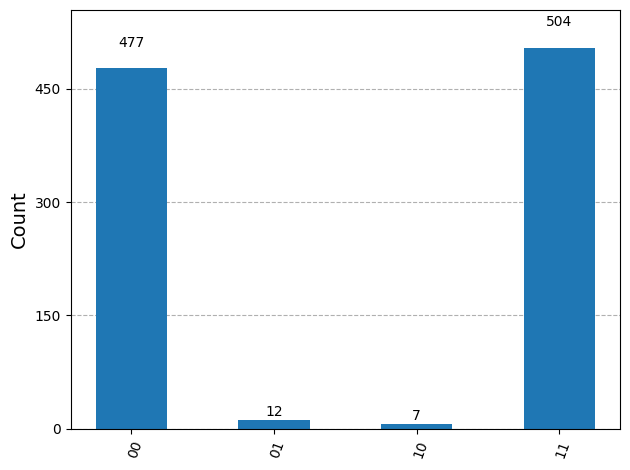

In [15]:

noise_model = NoiseModel()
prob_depolarisation = 0.05
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(prob_depolarisation, num_qubits=2), ["cx"]
)
sampler_noisy = Sampler(options=dict(backend_options=dict(noise_model=noise_model)))
result= sampler_noisy.run([qc_isa], shots=1000).result()
plot_histogram(result[0].data.meas.get_counts())